In [1]:
# get data

import pandas as pd

df = pd.read_csv('testdata/data_combined_24.csv', sep=',', names=["Category", "Sentence"])

# randomly sample data uniformly across categories
sampled = df.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))
print(len(sampled))

df.head()

# print all unique categories

print(sampled['Category'].unique())

2300
['business' 'computerscience' 'culture' 'disasters' 'economics'
 'education' 'entertainment' 'foods' 'geography' 'history' 'law'
 'mathematics' 'medicine' 'music' 'nature' 'news' 'philosophy' 'politics'
 'religion' 'science' 'sports' 'technology' 'videogames']


In [2]:
#convert text into BERT features

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

best_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
best_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = best_preprocess(text_input)
outputs = best_model(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
#run a sentence through the model to see what the output looks like

model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [3]:
#get features of all sentences in df
# add features to df

import numpy as np

features = model.predict(list(sampled.Sentence.to_numpy()))


#add features to df, create 512 feature columns



72/72 [==============================] - 159s 2s/step


In [4]:
for i in range(512):
    sampled['feature'+str(i)] = features[:,i]

sampled.head()

C:\Users\jfitz\AppData\Local\Temp\ipykernel_15232\3420900657.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sampled['feature'+str(i)] = features[:,i]
C:\Users\jfitz\AppData\Local\Temp\ipykernel_15232\3420900657.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sampled['feature'+str(i)] = features[:,i]
C:\Users\jfitz\AppData\Local\Temp\ipykernel_15232\3420900657.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

,Category,Sentence,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature502,feature503,feature504,feature505,feature506,feature507,feature508,feature509,feature510,feature511
10124,business,question pandemic created horrorthemed youtube...,0.476600,0.719539,-0.190689,-0.148131,0.062641,0.524870,0.991187,-0.984884,...,0.308812,-0.229811,-0.230379,-0.765770,0.138337,0.364476,0.117558,-0.023364,-0.193164,-0.419386
10241,business,looking advice diversifying everyone already r...,0.959758,0.680826,0.121719,0.187958,-0.028733,0.981248,0.978378,-0.835748,...,0.456432,-0.065902,0.752705,-0.845161,0.967324,0.441509,0.632634,-0.010366,-0.702728,-0.721294
27797,business,accordingly it should be guided by the provisi...,0.948676,-0.665642,0.185621,0.162189,-0.254144,0.999751,0.999696,-0.976197,...,0.079304,-0.054995,0.193736,-0.682264,-0.272329,-0.885679,0.456671,0.088437,-0.425841,-0.706113
9875,business,inflation peaked returning precovid levels mas...,0.661863,0.510459,-0.361144,-0.383658,0.400436,0.367822,0.996206,-0.882233,...,-0.017569,-0.107911,-0.205039,-0.934783,0.685684,-0.716564,-0.042916,0.536911,-0.266867,-0.772981
27413,business,these psychological processes involve four fac...,0.993400,-0.781366,-0.230843,0.652538,-0.225660,0.852456,0.974143,-0.947151,...,-0.155597,0.412730,0.440542,-0.616751,0.942798,-0.798880,0.327033,0.184807,-0.666195,-0.932829


In [98]:
#perform PCA on features

# filter for categories geography and nature

cat1 = "technology"
cat2 = "computerscience"

df_pca = sampled[sampled.Category.isin([cat1, cat2])]
categories = df_pca[['Category']]
categories = categories.reset_index(drop=True)

from sklearn.decomposition import PCA

pca = PCA(n_components=114)
principalComponents = pca.fit_transform(df_pca.iloc[:,114:])
principalDf = pd.DataFrame(data = principalComponents, columns = [f'pc{i}' for i in range(1,115)])

principalDf.head()

print(categories)
print(principalDf)


            Category
0    computerscience
1    computerscience
2    computerscience
3    computerscience
4    computerscience
..               ...
195       technology
196       technology
197       technology
198       technology
199       technology

[200 rows x 1 columns]
          pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0    5.015821 -2.244406  0.366876 -0.730236  2.162445  0.059876  1.347589   
1   -5.277351  6.416559 -1.118635 -0.336531  1.101648 -1.430870  0.617793   
2    1.018444  1.598052  4.320793 -0.031597  1.723081  1.784715  0.662240   
3    5.631291  2.441165  0.982538  0.254280 -1.577396  0.369054  0.193426   
4    0.547434 -1.061449  1.999667 -0.349616 -2.288188 -0.302175  0.481033   
..        ...       ...       ...       ...       ...       ...       ...   
195  6.261290  0.477352  0.218375  1.290691 -1.530364  2.473364 -0.213362   
196 -3.503108 -3.805473 -1.841657 -2.636143  1.540780  1.841373 -1.312313   
197  0.676331 -2.349820  0.4073

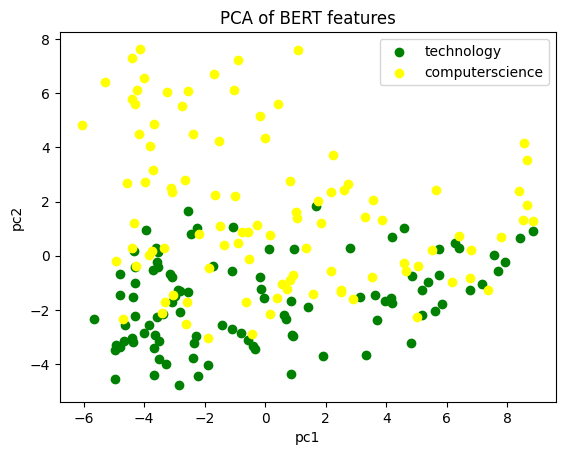

In [99]:
#plot top 2 PCs and color by category

import matplotlib.pyplot as plt

finalDf = pd.concat([principalDf, categories], axis = 1)

finalDf.head()

# get list of points for geography and nature
cat1data = finalDf[finalDf.Category == cat1]
cat2data = finalDf[finalDf.Category == cat2]

#randomly sample 100 points from each category
cat1data = cat1data.sample(n=100)
cat2data = cat2data.sample(n=100)

# plot points
plt.scatter(cat1data.pc1, cat1data.pc2, color='green')
plt.scatter(cat2data.pc1, cat2data.pc2, color='yellow')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('PCA of BERT features')

#add a legend
plt.legend([cat1, cat2])

plt.show()




In [130]:
#check linear seperability of the 2 categories using a perceptron

from sklearn.linear_model import Perceptron

#shuffle data
finalDf = finalDf.sample(frac=1).reset_index(drop=True)

#split into train and test
train = finalDf.iloc[:int(len(finalDf)*0.8),:]
test = finalDf.iloc[int(len(finalDf)*0.8):,:]

perceptron = Perceptron()

#test perceptron on 2 categories
perceptron.fit(train.iloc[:,0:2], train.Category)


#check accuracy
perceptron.score(test.iloc[:,0:2], test.Category)



0.7